In [22]:
# 모듈로딩
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn           
import torch.nn.functional as F 
import torch.optim as optim
import torchmetrics.functional as metrics
import torchmetrics.functional.classification as metrics
import sklearn.metrics as skm

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [23]:
featureDF = pd.read_pickle('./DATA/feature2.pkl')
targetDF = pd.read_pickle('./DATA/target2.pkl')

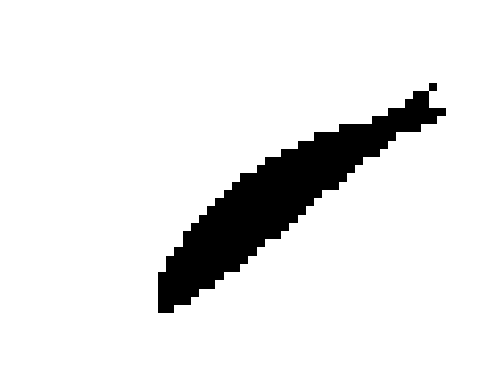

In [24]:
def plot_fish(image_data):
    image = image_data.reshape(45, 59)
    plt.imshow(image, cmap = 'binary')
    plt.axis('off')

some_fish = featureDF.iloc[0].values
plot_fish(some_fish)
plt.show()

In [25]:
some_fish.shape

(2655,)

In [26]:
# 학습을 위해 타겟 데이터를 시리즈로 변경
targetSR = targetDF.squeeze()
type(targetSR)

pandas.core.series.Series

In [27]:
# shape 확인
print(f'featureDF => {featureDF.shape}, targetSR => {targetSR.shape}')

featureDF => (9000, 2655), targetSR => (9000,)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 90, random_state = 42, stratify = targetSR)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 810, random_state = 42, stratify = y_train)

In [30]:
# 데이터의 Tensor 변환
class DLDataset(Dataset):

    # 초기화 콜백 함수(callback function)
    def __init__(self, x_data, y_data):
        super().__init__()
        # x, y 데이터 => ndarray
        x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data
        y_data = y_data.values if isinstance(y_data, pd.Series) else y_data

        # ndarray => tensor
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data)  # 타겟을 원핫인코딩하면 FloatTensor 사용
        print('[target & target shape]', self.target.shape, self.target.ndim)
    
    # 데이터셋의 개수 체크 콜백 함수(callback function)
    def __len__(self):
        return self.target.shape[0]
    
    # 특정 인덱스 데이터 + 라벨 반환 콜백 함수(callback function)
    def __getitem__(self, index):
        return self.feature[index], self.target[index]

In [31]:
trainDS = DLDataset(X_train, y_train)
validDS = DLDataset(X_val, y_val)
testDS = DLDataset(X_test, y_test)

[target & target shape] torch.Size([8100]) 1
[target & target shape] torch.Size([810]) 1
[target & target shape] torch.Size([90]) 1


In [32]:
batch_size = 50
trainDL = DataLoader(trainDS, batch_size = batch_size, shuffle = True, drop_last = True)
validDL = DataLoader(validDS, batch_size = batch_size, shuffle = True, drop_last = True)
testDL = DataLoader(testDS, batch_size = batch_size, shuffle = True, drop_last = True)

In [33]:
len(trainDL), len(validDL), len(testDL)

(162, 16, 1)

In [34]:
# Epoch당 반복 단위
print(f'batch_size = {batch_size}')
print(f'trainDL => {len(trainDL)}개, validDL => {len(validDL)}개, testDL => {len(testDL)}개')

batch_size = 50
trainDL => 162개, validDL => 16개, testDL => 1개


In [35]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSES = 9

### Dropout 미적용, Weight Initialization 미적용 <hr>

In [36]:
class FishModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim, nodes_list = []):
        super().__init__()
        nodes_list.insert(0, in_dim)
        nodes_list.append(out_dim)
        layer_num = len(nodes_list) - 1
        layers = []
        for i in range(layer_num):
            if i <= layer_num - 2:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
                layers.append(nn.BatchNorm1d(num_features = nodes_list[i+1]))
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Linear(nodes_list[i], nodes_list[i + 1]))
                
        self.layers = nn.ModuleList(layers)
               
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [37]:
### ===> 학습 진행함수 
def training(epoch):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장
    train_report=[[], [], []]
    for idx, (feature, target)  in enumerate(trainDL):
        # 배치크기만큼의 학습 데이터 준비
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        
        # 학습
        pre_traget = model(feature)
        
        # 손실계산
        loss = LOSS_FN(pre_traget, target)
        train_report[0].append(loss)
        
        # 성능 평가
        acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes = 9)
        train_report[1].append(acc)
        
        f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes = CLASSES)
        train_report[2].append(f1)
        
        # W,b업데이트
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        
        if not idx%50: print('.', end='')
    
    # 에포크 단위로 학습 모델 저장
    # torch.save(model, './model/my_model.pt')
    
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(train_report[0])/batch_size).item()
    acc_score = (sum(train_report[1])/batch_size).item()
    f1_score = (sum(train_report[2])/batch_size).item() 
    print(f'\n[{epoch+1} Train ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}')
    
    return loss_score, acc_score, f1_score

In [38]:
### ===> 검증 및 테스트 진행함수 
def testing(epoch, kind='valid'):
    # 학습모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 활성화 
    model.eval()
        
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장
        test_report=[[], [], []]
        for idx, (feature, target) in enumerate(trainDL):
            # 배치크기만큼의 학습 데이터 준비
            feature, target = feature.to(DEVICE), target.to(DEVICE)

            # 학습
            pre_traget = model(feature)

            # 손실계산
            loss = LOSS_FN(pre_traget, target)
            test_report[0].append(loss)
            
            # 성능 평가 
            acc = metrics.accuracy(pre_traget, target, task='multiclass', num_classes=CLASSES)
            test_report[1].append(acc)
            
            f1 = metrics.f1_score(pre_traget, target, task='multiclass', num_classes=CLASSES)
            test_report[2].append(f1)
            
            #if not idx%50: print('.', end='')

    testing_type = 'Valid' if kind == 'valid' else 'Test'
        
    # 에포크 단위 학습 진행 메시지 출력
    loss_score = (sum(test_report[0])/batch_size).item()
    acc_score = (sum(test_report[1])/batch_size).item()
    f1_score = (sum(test_report[2])/batch_size).item() 
    print(f'[{epoch+1} {testing_type} ] Loss ==> {loss_score:.3f} Acc ==> {acc_score:.3f} F1 ==> {f1_score:.3f}\n')
    
    return loss_score, acc_score, f1_score

- 은닉층 1~10개 퍼셉트론 수 16개로 고정

In [39]:
layer_list1 = [[16 for j in range(i+1)] for i in range(10)]

loss_list1 = [[], []]
acc_list1 = [[], []]
f1_score_list1 = [[], []]

EPOCHS = 30
for layer in layer_list1:
    IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
    model = FishModel(IN_DIM, OUT_DIM, layer)
    OPTIMIZER = optim.Adam(model.parameters())
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
    SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
    

    train_ = {'loss':[], 'acc':[], 'f1':[]}
    val_ = {'loss':[], 'acc':[], 'f1':[]}

    pre_va_score = 100

    for epo in range(EPOCHS):
        print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    
        tr_score=training(epo)
        va_score=testing(epo)
    
        if pre_va_score > va_score[0]:
            torch.save(model, './model1/my_model1.pt')
            pre_va_score = va_score[0]

        for idx, key in enumerate(train_):
            train_[key].append(tr_score[idx])
            val_[key].append(va_score[idx])
        
        SCHEDULER.step(va_score[0])
        # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
        if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
            print(f'Early stopping at epoch {epo}')
            break
        
    loss_list1[0].append(train_['loss'][-1])
    loss_list1[1].append(val_['loss'][-1])
    acc_list1[0].append(train_['acc'][-1])
    acc_list1[1].append(val_['acc'][-1])
    f1_score_list1[0].append(train_['f1'][-1])
    f1_score_list1[1].append(val_['f1'][-1])

    print("Done!")

[Epoch 1/30] .

...
[1 Train ] Loss ==> 5.587 Acc ==> 1.303 F1 ==> 1.303
[1 Valid ] Loss ==> 4.679 Acc ==> 1.712 F1 ==> 1.712

[Epoch 2/30] ....
[2 Train ] Loss ==> 4.426 Acc ==> 1.713 F1 ==> 1.713
[2 Valid ] Loss ==> 3.940 Acc ==> 1.862 F1 ==> 1.862

[Epoch 3/30] ....
[3 Train ] Loss ==> 3.837 Acc ==> 1.875 F1 ==> 1.875
[3 Valid ] Loss ==> 3.456 Acc ==> 2.060 F1 ==> 2.060

[Epoch 4/30] ....
[4 Train ] Loss ==> 3.467 Acc ==> 2.003 F1 ==> 2.003
[4 Valid ] Loss ==> 3.157 Acc ==> 2.165 F1 ==> 2.165

[Epoch 5/30] ....
[5 Train ] Loss ==> 3.144 Acc ==> 2.125 F1 ==> 2.125
[5 Valid ] Loss ==> 2.788 Acc ==> 2.281 F1 ==> 2.281

[Epoch 6/30] ....
[6 Train ] Loss ==> 2.901 Acc ==> 2.201 F1 ==> 2.201
[6 Valid ] Loss ==> 2.737 Acc ==> 2.320 F1 ==> 2.320

[Epoch 7/30] ....
[7 Train ] Loss ==> 2.685 Acc ==> 2.284 F1 ==> 2.284
[7 Valid ] Loss ==> 2.425 Acc ==> 2.435 F1 ==> 2.435

[Epoch 8/30] ....
[8 Train ] Loss ==> 2.477 Acc ==> 2.389 F1 ==> 2.389
[8 Valid ] Loss ==> 2.167 Acc ==> 2.482 F1 ==> 2.482

[Epoch 9/30] .

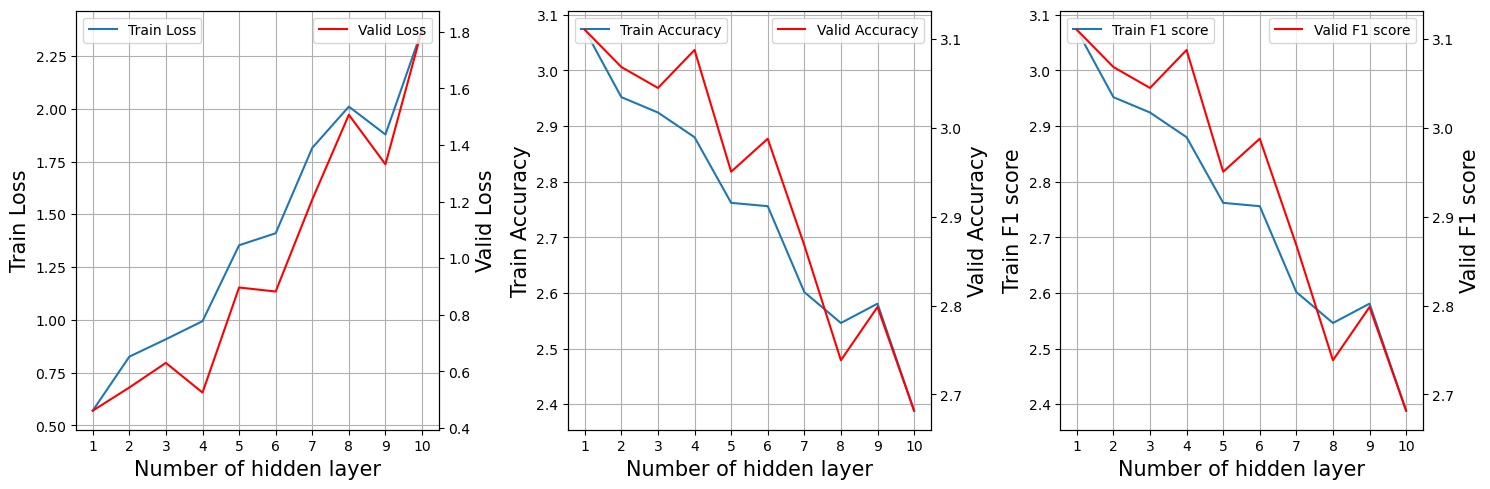

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list1[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Number of hidden layer", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(10))
axes[0].set_xticklabels(np.arange(1, 11))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list1[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list1[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Number of hidden layer", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(10))
axes[1].set_xticklabels(np.arange(1, 11))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list1[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list1[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Number of hidden layer", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(10))
axes[2].set_xticklabels(np.arange(1, 11))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list1[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()

- 은닉층 1~10개, 퍼셉트론 수 32개로 고정

In [46]:
layer_list2 = [[32 for j in range(i+1)] for i in range(10)]

loss_list2 = [[], []]
acc_list2 = [[], []]
f1_score_list2 = [[], []]

EPOCHS = 30
for layer in layer_list2:
    IN_DIM, OUT_DIM = X_train.shape[1], y_train.nunique()
    model = FishModel(IN_DIM, OUT_DIM, layer)
    OPTIMIZER = optim.Adam(model.parameters())
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE)
    SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 5)
    
    train_ = {'loss':[], 'acc':[], 'f1':[]}
    val_ = {'loss':[], 'acc':[], 'f1':[]}

    pre_va_score = 100

    for epo in range(EPOCHS):
        print(f"[Epoch {epo+1}/{EPOCHS}] ", end='')
    
        tr_score=training(epo)
        va_score=testing(epo)
    
        if pre_va_score > va_score[0]:
            torch.save(model, './model1/my_model2.pt')
            pre_va_score = va_score[0]

        for idx, key in enumerate(train_):
            train_[key].append(tr_score[idx])
            val_[key].append(va_score[idx])
        
        SCHEDULER.step(va_score[0])
        # 조기종료 기능 => 조건 : val_loss가 지정된 횟수이상 개선이 안되면 학습 종료
        if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
            print(f'Early stopping at epoch {epo}')
            break
        
    loss_list2[0].append(train_['loss'][-1])
    loss_list2[1].append(val_['loss'][-1])
    acc_list2[0].append(train_['acc'][-1])
    acc_list2[1].append(val_['acc'][-1])
    f1_score_list2[0].append(train_['f1'][-1])
    f1_score_list2[1].append(val_['f1'][-1])

    print("Done!")

[Epoch 1/30] ....
[1 Train ] Loss ==> 4.983 Acc ==> 1.445 F1 ==> 1.445
[1 Valid ] Loss ==> 4.047 Acc ==> 1.821 F1 ==> 1.821

[Epoch 2/30] ....
[2 Train ] Loss ==> 3.890 Acc ==> 1.835 F1 ==> 1.835
[2 Valid ] Loss ==> 3.396 Acc ==> 2.076 F1 ==> 2.076

[Epoch 3/30] ....
[3 Train ] Loss ==> 3.382 Acc ==> 1.996 F1 ==> 1.996
[3 Valid ] Loss ==> 2.977 Acc ==> 2.195 F1 ==> 2.195

[Epoch 4/30] ....
[4 Train ] Loss ==> 3.016 Acc ==> 2.159 F1 ==> 2.159
[4 Valid ] Loss ==> 2.607 Acc ==> 2.377 F1 ==> 2.377

[Epoch 5/30] ....
[5 Train ] Loss ==> 2.727 Acc ==> 2.254 F1 ==> 2.254
[5 Valid ] Loss ==> 2.351 Acc ==> 2.468 F1 ==> 2.468

[Epoch 6/30] ....
[6 Train ] Loss ==> 2.474 Acc ==> 2.364 F1 ==> 2.364
[6 Valid ] Loss ==> 2.211 Acc ==> 2.476 F1 ==> 2.476

[Epoch 7/30] ....
[7 Train ] Loss ==> 2.235 Acc ==> 2.466 F1 ==> 2.466
[7 Valid ] Loss ==> 1.841 Acc ==> 2.637 F1 ==> 2.637

[Epoch 8/30] ....
[8 Train ] Loss ==> 2.011 Acc ==> 2.532 F1 ==> 2.532
[8 Valid ] Loss ==> 1.830 Acc ==> 2.647 F1 ==> 2.647



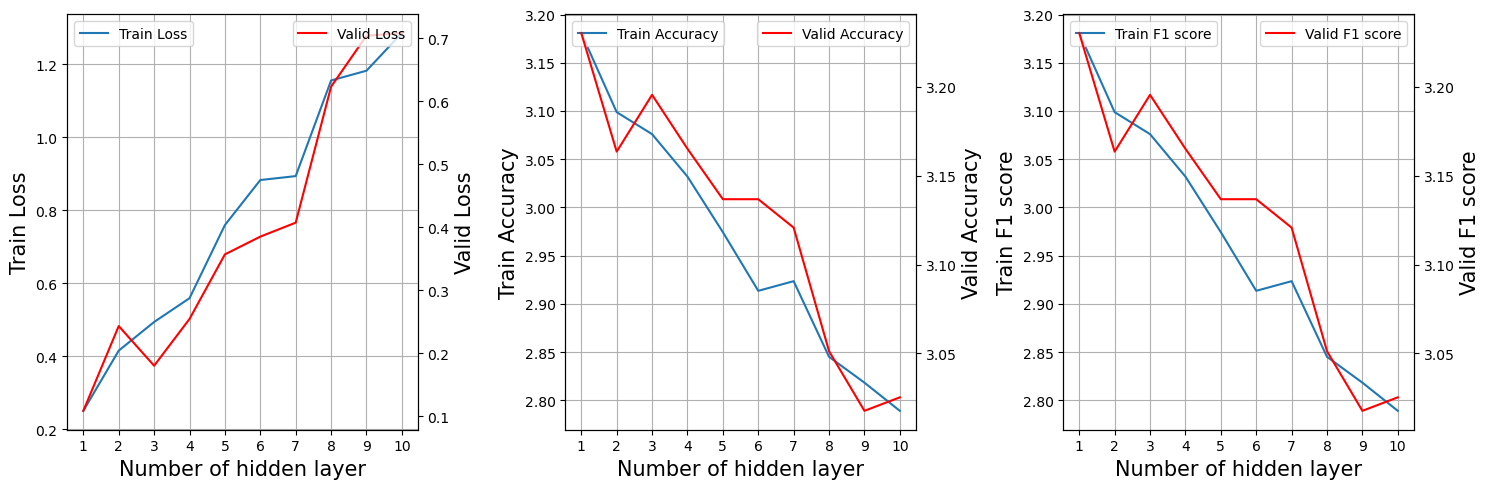

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(loss_list2[0], label = "Train Loss")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Number of hidden layer", size = 15)
axes[0].set_ylabel("Train Loss", size = 15)
axes[0].set_xticks(np.arange(10))
axes[0].set_xticklabels(np.arange(1, 11))
axes[0].grid()
axes2 = axes[0].twinx()
axes2.plot(loss_list2[1], label = "Valid Loss", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Loss", size = 15)

axes[1].plot(acc_list2[0], label = "Train Accuracy")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Number of hidden layer", size = 15)
axes[1].set_ylabel("Train Accuracy", size = 15)
axes[1].set_xticks(np.arange(10))
axes[1].set_xticklabels(np.arange(1, 11))
axes[1].grid()
axes2 = axes[1].twinx()
axes2.plot(acc_list2[1], label = "Valid Accuracy", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid Accuracy", size = 15)

axes[2].plot(f1_score_list2[0], label = "Train F1 score")
axes[2].legend(loc="upper left")
axes[2].set_xlabel("Number of hidden layer", size = 15)
axes[2].set_ylabel("Train F1 score", size = 15)
axes[2].set_xticks(np.arange(10))
axes[2].set_xticklabels(np.arange(1, 11))
axes[2].grid()
axes2 = axes[2].twinx()
axes2.plot(f1_score_list2[1], label = "Valid F1 score", color = "red")
axes2.legend(loc="upper right")
axes2.set_ylabel("Valid F1 score", size = 15)
plt.tight_layout()
plt.show()

In [ ]:
# 테스트
pre_target = predict(testDS)
test_accuracy = metrics.accuracy(pre_target, testDS.target, task = 'multiclass', num_classes = CLASSES)

print(f'Test Accuracy ===> {test_accuracy.item():.2f}')

NameError: name 'predict' is not defined

In [ ]:
pre_target.shape

torch.Size([90])

[[5 0 1 0 0 0 2 0 0]
 [0 9 0 0 1 0 0 0 2]
 [1 0 7 0 0 0 0 0 1]
 [0 0 1 6 0 0 3 2 0]
 [0 0 0 0 9 0 0 0 0]
 [1 0 0 2 0 9 0 0 0]
 [2 0 0 0 0 0 1 0 0]
 [1 0 1 2 0 1 4 8 0]
 [0 1 0 0 0 0 0 0 7]]


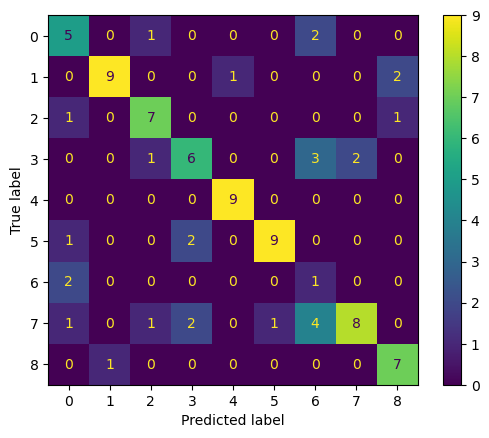

In [ ]:
# (정답, 예측)
con = skm.confusion_matrix(pre_target, testDS.target)
print(con)

# 시각화
conDisplay = skm.ConfusionMatrixDisplay(con)
conDisplay.plot()
plt.show()

In [ ]:
# 다중 분류 성능분석 출력 - 불균형 데이터셋인 경우
p_score = skm.precision_score(pre_target, testDS.target, average = 'macro')
r_score = skm.recall_score(pre_target, testDS.target, average = 'macro')
f1_score = skm.f1_score(pre_target, testDS.target, average = 'macro')
a_score = skm.accuracy_score(pre_target, testDS.target)
report = skm.classification_report(pre_target, testDS.target)

print(f'Target ==> {pre_target}')
print(f'testDS.target ==> {testDS.target}\n')
print(f'[precision] : {p_score}\n[Recall] : {r_score}\n[F1-score] : {f1_score}\n[Accuracy] : {a_score}')
print(f'\n[REPORT]\n{report}')

Target ==> tensor([6, 8, 0, 2, 7, 5, 7, 4, 5, 7, 0, 7, 3, 1, 1, 7, 4, 2, 0, 2, 2, 0, 1, 1,
        7, 7, 3, 3, 8, 7, 7, 1, 8, 5, 7, 0, 5, 5, 1, 4, 0, 1, 2, 3, 8, 7, 7, 5,
        4, 5, 3, 3, 4, 2, 7, 7, 8, 5, 1, 3, 1, 5, 5, 3, 5, 5, 3, 2, 6, 7, 4, 4,
        2, 1, 1, 3, 0, 3, 6, 8, 4, 7, 1, 2, 0, 7, 3, 4, 8, 8])
testDS.target ==> tensor([0, 8, 0, 2, 5, 5, 0, 4, 5, 7, 6, 2, 7, 1, 1, 3, 4, 2, 6, 8, 2, 0, 1, 1,
        7, 3, 7, 3, 8, 6, 7, 8, 8, 5, 7, 0, 5, 5, 1, 4, 0, 1, 2, 2, 8, 6, 7, 3,
        4, 0, 3, 6, 4, 0, 6, 7, 8, 5, 1, 3, 1, 3, 5, 3, 5, 5, 3, 2, 6, 6, 4, 4,
        2, 8, 1, 6, 0, 6, 0, 8, 4, 7, 4, 2, 2, 7, 3, 4, 8, 1])

[precision] : 0.6777777777777778
[Recall] : 0.6757443718228031
[F1-score] : 0.6606445319895612
[Accuracy] : 0.6777777777777778

[REPORT]
              precision    recall  f1-score   support

           0       0.50      0.62      0.56         8
           1       0.90      0.75      0.82        12
           2       0.70      0.78      0.74         9
          

In [ ]:
# 저장된 모델 불러오기
mymodel = torch.load('./model/my_model.pt')
mymodel

MNISTModel(
  (layers): ModuleList(
    (0): Linear(in_features=15000, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=9, bias=True)
  )
)